# Анализ оттока клиентов банка

В нашем распоряжении имеются данные о клиентах регионального банка «Метанпром», который находится в Ярославле и областных городах: Ростове Великом и Рыбинске. Главной задачей является анализ оттока клиентов.

**Цель исследования:** 

Нужно определить ключевые факторы, влияющие на отток клиентов, и выделить группы пользователей, которые с большей вероятностью могут уйти из банка. Для каждой такой группы мы разработаем адресные рекомендации, направленные на снижение уровня оттока клиентов.

---
**Ход исследования:**

1 — Обзор данных\
2 — Предобработка данных\
3 — Исследовательский анализ\
4 — Формулировка и проверка гипотез\
5 — Сегментация и приоритизация сегментов\
6 — Формирование рекомендаций

---
**Описание данных**

Файл `bank_scrooge.csv`:

* `USERID` — идентификатор пользователя,
* `score` — баллы кредитного скоринга,
* `city` — город,
* `gender` — пол,
* `age` — возраст,
* `equity` — количество баллов собственности
* `balance` — баланс на счёте,
* `products` — количество продуктов, которыми пользуется клиент,
* `credit_card` — есть ли кредитная карта,
* `last_activity` — активный клиент,
* `EST_SALARY` — оценочный доход клиента,
* `сhurn` — признак оттока.

## Загрузка данных и изучение общей информации

In [1]:
# импорт библиотек Python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import phik
import matplotlib.ticker as ticker
from scipy import stats as st
import math as mth
import statistics as stat

In [2]:
warnings.filterwarnings("ignore")  # отключаем предупреждения об изменениях в библиотеках
path = "https://code.s3.yandex.net/datasets/"
data = pd.read_csv(path + "bank_scrooge.csv")  # сохраняем датасет в переменную 'data'
sns.set_palette("Set2")# задаем цвета для библиотеки seaborn

Выведем на экран первые пять строк датасета, применим методы info() и describe().

In [3]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [5]:
data.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


### Промежуточные выводы

* В датасете содержится 10 000 строк.
* В столбцах age и balance присутствуют пропуски.
* Необходимо преобразовать наименования столбцов USERID и EST_SALARY в нижний регистр.
* Также требуется изменить типы данных для следующих столбцов:
    * score — с float64 на int64;
    * age — с float64 на int64;
* Необходимо проверить строки на наличие дубликатов строк, а также скрытые дубликаты в столбцах `city` и `gender`.
* Нужно убедиться, что все значения в столбце `USERID` уникальны, так как он содержит уникальные идентификаторы пользователей.
* Для бинарных показателей нужно проверить, чтобы там были только значения 0 или 1.
* Следует изучить нулевые значения в столбце `products` — у действующих клиентов банка должен быть хотя бы один продукт, значение 0 недопустимо.

## Предобработка данных

### Приведение названий столбцов к единому регистру

In [6]:
data.columns = data.columns.str.lower()  # переводим в нижний регистр
data = data.rename(
    columns={"userid": "user_id"}
)  # userid переводим в змеиный регистр для единообразия

### Поиск и устранение дубликатов

#### Поиск явных дубликатов

Сначала проверим датасет на наличие полностью повторяющихся строк:

In [7]:
data.duplicated().sum()

0

Полностью повторяющихся строк нет.

#### Поиск неявных дубликатов

Такие дубликаты могут содержать строковые столбцы 'city' и 'gender'.

In [8]:
print("Уникальные значения в столбце city", data["city"].unique())
print("Уникальные значения в столбце gender", data["gender"].unique())

Уникальные значения в столбце city ['Рыбинск' 'Ярославль' 'Ростов']
Уникальные значения в столбце gender ['Ж' 'М']


Опечаток и ошибок в столбцах нет.

Теперь проверим столбец `user_id`. Из описания данных следует, что значения в нем должны быть уникальны.

In [9]:
print("Количество дубликатов в столбце user_id =", data["user_id"].duplicated().sum())

Количество дубликатов в столбце user_id = 73


У 73 пользователей более одной строки.

Посмотрим на эти дубли поближе.

In [10]:
data[data[["user_id"]].duplicated(keep=False) == True].sort_values(by="user_id").head(
    10
)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


**Наблюдения:** Судя по всему в строках—дублях находится информация о разных людях, так как у них зачастую различны города проживания, возраст, пол и так далее, поэтому было бы неверно удалять одну из строк-дублей.\
В контексте нашего исследования столбец user_id не несет полезной информации, поэтому можно его удалить.

In [11]:
# удаляем лишний столбец user_id
data = data.drop(columns=["user_id"])

Проверим столбцы, содержащие бинарные признаки, на ошибки. Для этого выведем для каждого столбца уникальные значения.\
Ими могут быть только 1 или 0.

In [12]:
display(data["credit_card"].unique())
display(data["last_activity"].unique())
data["churn"].unique()

array([0, 1])

array([1, 0])

array([1, 0])

Все хорошо.\
Теперь изучим нулевые значения в столбце `products`

In [13]:
data.query("products == 0")

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


Такой клиент только один. Это ушедший из банка клиент, который уже не пользуется ни одним продуктом. Видимо его по каким-то причинам не удалили из клиентской базы.
Корректно было бы удалить эту строку.

In [14]:
data = data.query("products != 0")

### Работа с пропусками

Выше мы уже уточнили, что пропуски встречаются только в двух столбцах: `age` и `balance`.\
Сначала изучим столбец `age`.\
Вычислим процент пропусков от общего числа строк и выведем строки с пропусками в этом столбце на экран.

In [15]:
print(
    "\033[1m\nКоличество строк с пропусками в столбце age =",
    len(data.query("age.isna()")),
)
print(
    "\033[1m\nДоля пропусков относительно общего количества строк =",
    "{0:.2f}%".format(len(data.query("age.isna()")) / len(data) * 100),
    "\n\033[0m",
)

data.query("age.isna()")


Количество строк с пропусками в столбце age = 26

Доля пропусков относительно общего количества строк = 0.26% 



,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


**Наблюдения:**
* Пропуски в столбце 'age' встречаются только у жителей Ярославль и Рыбинска. Возможно, это связано с особенностями внесения данных о новых клиентах.
* В строках с пропусками в столбце возраста также зачастую отсутствует информация о балансе.

Так как пропуски в этом столбце составляют менее одного процента всего объема данных, можно их удалить.

In [16]:
data = data.dropna(subset=["age"])

Перейдем к столбцу `balance`.
Вычислим процент пропусков от общего числа строк и выведем первые десять строк с пропусками в этом столбце на экран.

In [17]:
print(
    "\033[1m\nКоличество строк с пропусками в столбце balance =",
    len(data.query("balance.isna()")),
)

print(
    "\033[1m\nДоля пропусков относительно общего количества строк равна",
    "{0:.2f}%".format(len(data.query("balance.isna()")) / len(data) * 100),
    "\n\033[0m",
)

data.query("balance.isna()").head(10)


Количество строк с пропусками в столбце balance = 2278

Доля пропусков относительно общего количества строк равна 22.84% 



,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
21,896.0,Рыбинск,Ж,47.0,0,NaN,1,0,0,225060.35,0
30,946.0,Ярославль,Ж,47.0,0,NaN,2,1,1,660015.85,0
34,944.0,Ярославль,М,35.0,0,NaN,2,1,1,239843.39,0
39,924.0,Рыбинск,Ж,51.0,0,NaN,1,1,1,248844.47,0
43,956.0,Ростов,М,41.0,0,NaN,1,1,0,115117.10,0


**Наблюдения:**
Мы видим, что в этом столбце отсутствуют данные для 23% записей. Определим, есть ли связь между отсутствием значений и другими характеристиками. Это поможет классифицировать пропуски и выработать стратегию их обработки.

---

Создадим новый столбец `balance_missing` со значениями:
* 1 — в наблюдении пропущено значение признака
* 0 — в наблюдении значение признака не пропущено.

На основе нового столбца составим сводную таблицу, в которой рассчитаем разницу в данных между клиентами с пропуском и без него.

In [18]:
# создаем новый столбец
data["balance_missing"] = data["balance"].isna()

# создаем сводную таблицу по всем признакам
data.pivot_table(
    index="balance_missing",
    values=[
        "score",
        "age",
        "city",
        "est_salary",
        "gender",
        "equity",
        "products",
        "credit_card",
        "last_activity",
        "churn",
    ],
    aggfunc={
        "score": np.mean,
        "age": np.mean,
        "est_salary": np.mean,
        "gender": stat.mode,
        "city": stat.mode,
        "equity": np.median,
        "products": np.median,
        "credit_card": np.mean,
        "last_activity": np.mean,
        "churn": np.mean
    },
)

,age,churn,city,credit_card,equity,est_salary,gender,last_activity,products,score
balance_missing,,,,,,,,,,
False,42.924366,0.234698,Ярославль,0.640156,4.0,124520.394264,Ж,0.515140,2.0,843.74412
True,42.076822,0.005268,Ярославль,0.815628,0.0,226433.776313,М,0.549166,1.0,865.31475


**Наблюдения:**

Мы выделили общие черты у клиентов с пропущенными значениями в столбце «balance»:
* среди них гораздо меньше отточных клиентов;
* больше владельцев кредитных карт;
* средняя зарплата почти в два раза выше;
* мужчин больше, чем женщин;
* меньше баллов собственности;
* меньше банковских продуктов.

---

Таким образом, пропуски в этом столбце относятся к категории MNAR (Missing Not At Random / Отсутствует неслучайно). Это означает, что пропуски зависят от данных, и их нельзя просто удалить или заполнить одним значением, так как это приведёт к значительным искажениям. В то же время сложно определить, какими значениями было бы логично заполнить пропуски.

**Поэтому мы оставим пропуски в данном столбце без изменений.**

In [19]:
data = data.drop(
    columns=["balance_missing"]
)  # удалим вспомогательный столбец 'balance_missing'

### Изменение типов данных

Изменим типы данных для следующих столбцов:
* `score` — с float64 на int64;
* `age` — с float64 на int64

In [20]:
# меняем типы данных
data["score"] = data["score"].astype("int64")
data["age"] = data["age"].astype("int64")

### Промежуточный вывод

Мы подготовили данные к работе:
* Привели столбцы к единому регистру
* Проверили данные на наличие явных и скрытых дубликатов, а также нашли строку с клиентом, у которого нет продуктов банка
* Приняли решения о строках, содержащих пропуски
* Поменяли типы данных, где это уместно

## Исследовательский анализ данных

Вычислим долю оттока по общим данным и запишем результат в переменную.

In [21]:
overall_churn = data["churn"].mean()

print(
    "\033[1mСредний уровень оттока по банку =",
    "{0:.2f}%".format(data["churn"].mean() * 100),
    "\n\033[0m",
)

Средний уровень оттока по банку = 18.23% 



Нам нужно выявить признаки клиентов, которые могут привести к их оттоку.

<p style="text-align:center;"><b>Разделим столбцы на две категории:</b>
</p>


|непрервные признаки | категориальные/дискретные признаки | 
|--------------------|------------------------------------|
| score,             | city,                              | 
| age                | gender                             | 
| balance            | equity                             | 
| est_salary         | products                           | 
|                    | credit_card                        | 
|                    | last_activity                      | 




### Категориальные/дискретные признаки

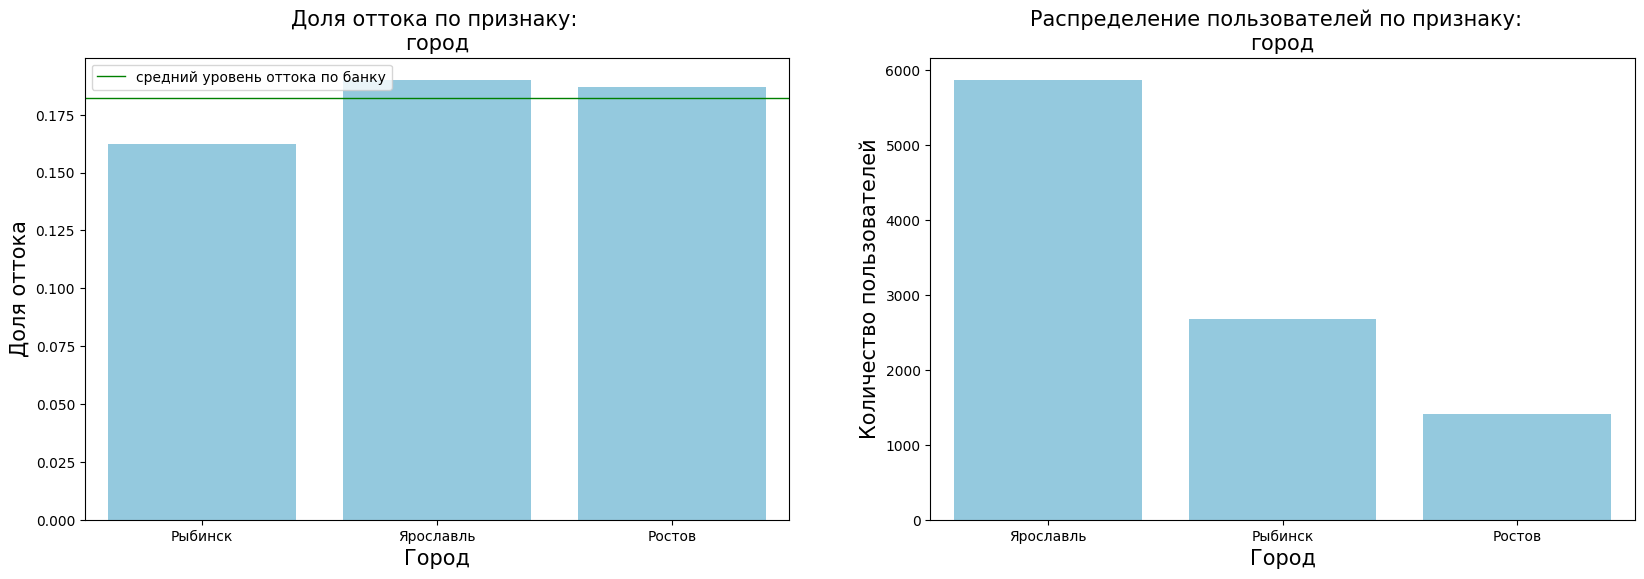

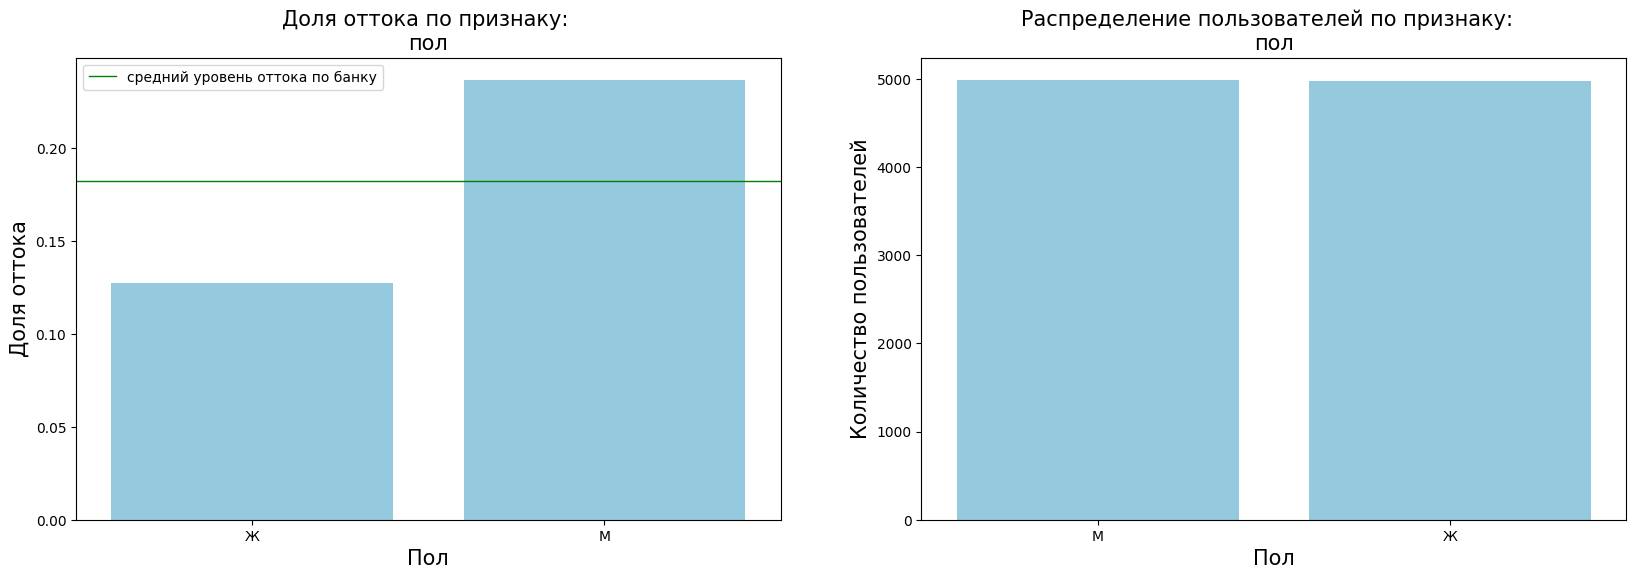

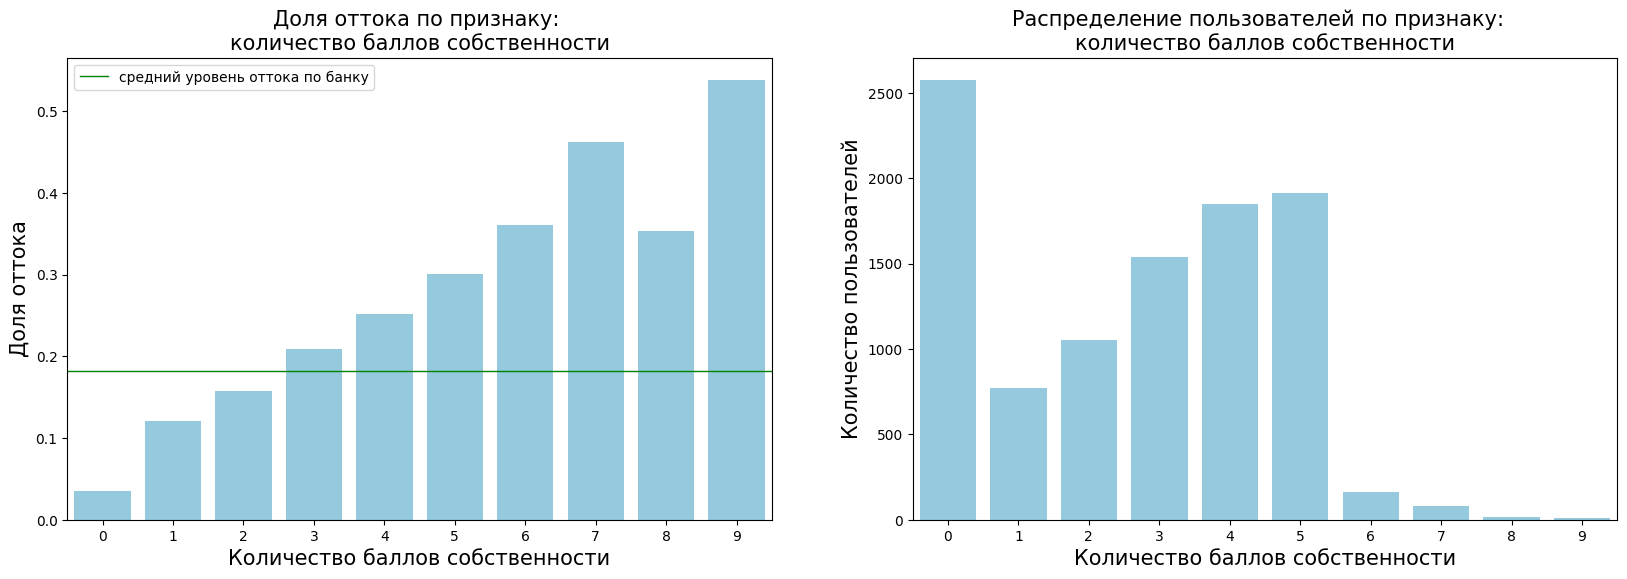

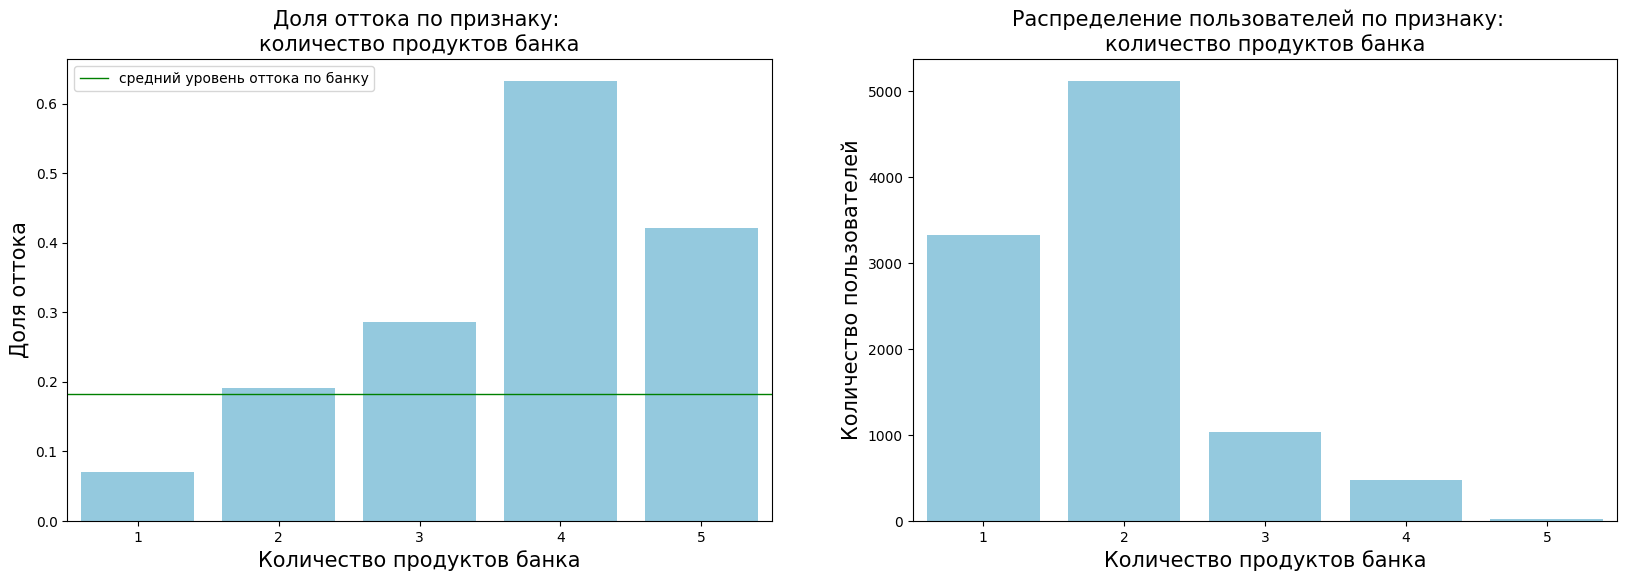

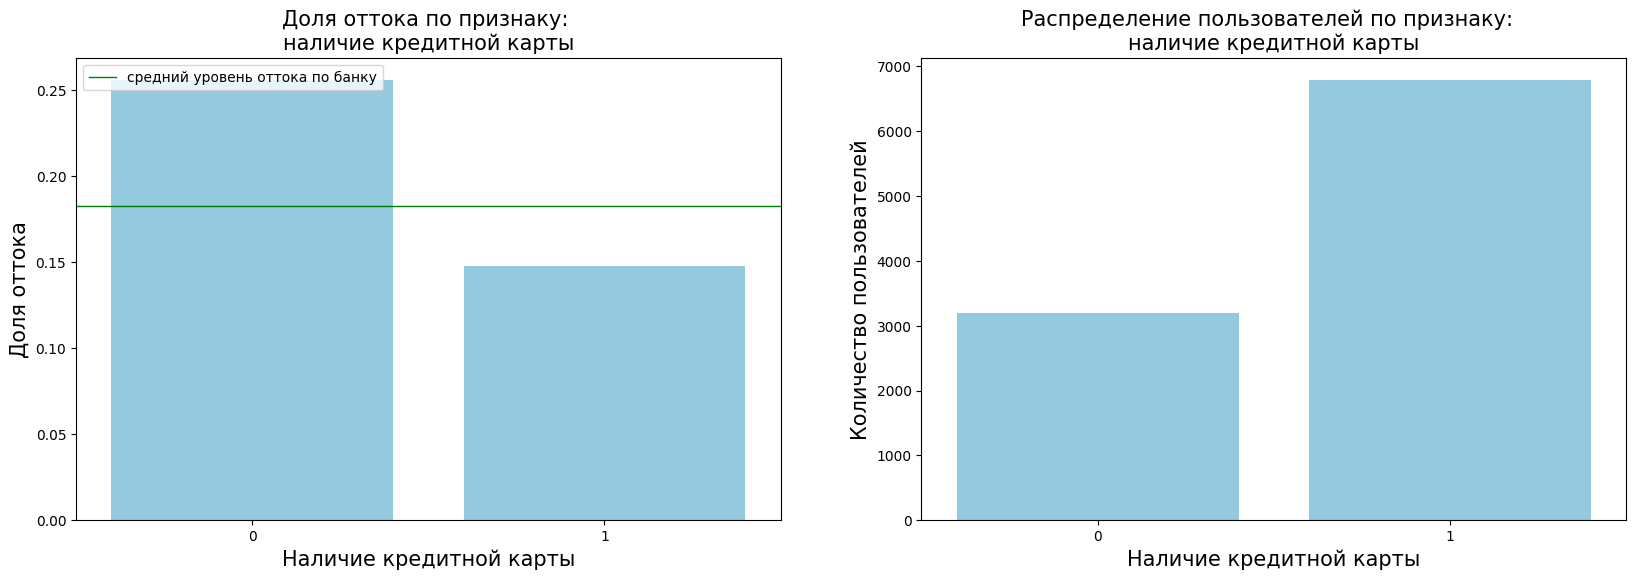

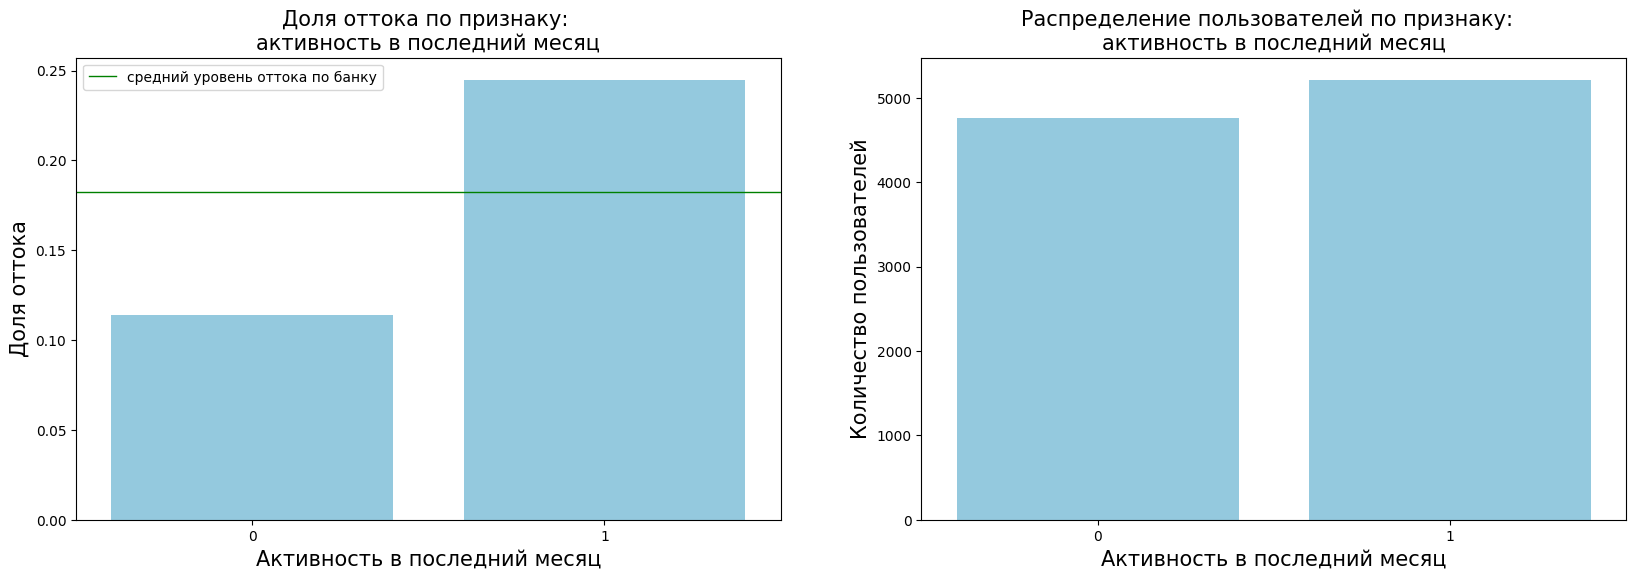

In [22]:
# создаем вспомогательный словарь с переводом названий столбцов на русский язык
columndict = {
    "city": "Город",
    "gender": "Пол",
    "equity": "Количество баллов собственности",
    "products": "Количество продуктов банка",
    "credit_card": "Наличие кредитной карты",
    "last_activity": "Активность в последний месяц",
    "score": "Количество баллов кредитного скоринга",
    "age": "Возраст клиента",
    "balance": "Баланс на счёте",
    "est_salary": "Оценочный доход клиента",
}

# создаем лист категориальных и дискретных признаков
list_1 = ["city", "gender", "equity", "products","credit_card", "last_activity"]

# цикл создает два графика для каждого признака из list_1
for column in list_1:

    # создаем фигуру из двух графиков
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(20, 6)

    # график №1 отражает долю оттока в категории
    sns.barplot(ax=axes[0], data=data, x=column, y="churn", ci=None, color="skyblue")
    axes[0].axhline(
        overall_churn, color="g", linestyle="-", linewidth=1, label="horizontal"
    )
    axes[0].legend(
        loc="upper left", fontsize=10, labels=["средний уровень оттока по банку"]
    )
    title = "Доля оттока по признаку: \n" + str.lower(columndict[column])
    axes[0].set_title(title, fontsize="15")
    axes[0].set_xlabel(columndict[column], fontsize="15")
    axes[0].set_ylabel("Доля оттока", fontsize="15")

    slice = data[column].value_counts().reset_index()
    
    # график №2 отражает распределение пользователей по признаку
    sns.barplot(
        ax=axes[1], data=slice, x=column, y="count", color="skyblue"
    )
    title = "Распределение пользователей по признаку:  \n" + str.lower(
        columndict[column]
    )
    axes[1].set_title(title, fontsize="15")
    axes[1].set_xlabel(columndict[column], fontsize="15")
    axes[1].set_ylabel("Количество пользователей", fontsize="15")

    plt.show();

**Наблюдения:**

На основе изученных данных можно сделать следующие выводы:

* **Город:** клиенты из Ярославля и Ростова имеют уровень оттока выше среднего. Больше всего клиентов из Ярославля.  Разница в отточности между городами в целом не велика.
* **Пол:** мужчины демонстрируют значительно более высокий уровень оттока, чем женщины. В датафрейме примерно равное количество мужчин и женщин.
* **Количество баллов собственности:** у клиентов с тремя и более баллами собственности уровень оттока выше среднего по банку. При этом большинство клиентов имеют нулевой балл собственности.
* **Количество продуктов банка:** клиенты, пользующиеся двумя и более продуктами банка, имеют уровень оттока выше среднего по банку. У большинства клиентов два или один продукт.
* **Наличие кредитной карты:** клиенты без кредитной карты банка более склонны к оттоку, хотя таких клиентов меньше.
* **Активность за последний месяц:** клиенты, активные в последний месяц, более склонны к оттоку. Их немного больше в датасете.

---

Теперь перейдем к непрерывным признакам.

### Непрерывные признаки

#### Возраст

Возраст в датафрейме представлен дискретными величинами с округлением до года, несмотря на то, что возраст — непрерывная величина.

Давайте создадим две визуализации:

* гистограмму, которая покажет распределение плотности по признаку оттока;
* столбчатую диаграмму, отражающую средний уровень оттока для каждого возраста в датафрейме.

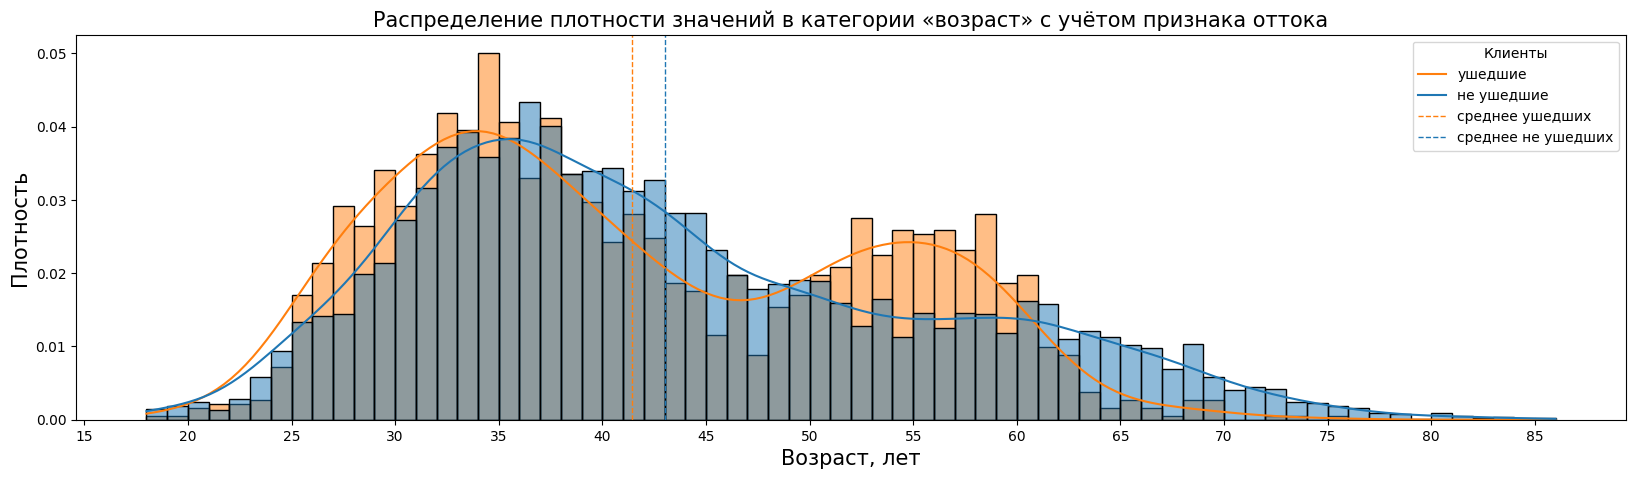

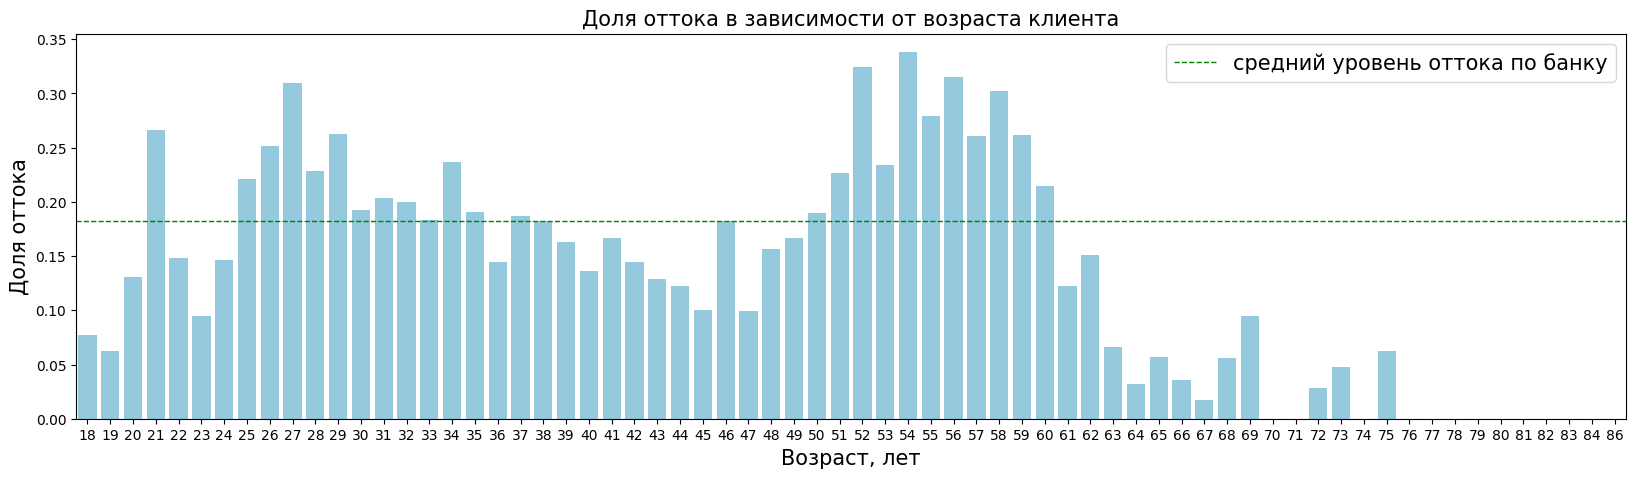

In [23]:
sns.set_palette("tab10")  # задаем цвета для библиотеки seaborn

# график №1 - гистограмма плотности признака с делением по оттоку
plt.figure(figsize=(20, 5))
sns.histplot(
    data=data,
    x="age",
    hue="churn",
    stat="density",
    common_norm=False,
    kde=True,
    binwidth=1,
)
plt.title(
    "Распределение плотности значений в категории «возраст» с учётом признака оттока",
    fontsize="15",)

plt.xlabel("Возраст, лет", fontsize="15")
plt.ylabel("Плотность", fontsize="15")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.axvline(
    data.query("churn == 1")["age"].mean(),
    color="#ff7f0e",
    linestyle="--",
    linewidth=1,
)

plt.axvline(
    data.query("churn == 0")["age"].mean(),
    color="#1f77b4",
    linestyle="--",
    linewidth=1,
)

plt.legend(
    fontsize=10,
    title="Клиенты",
    loc="upper right",
    labels=["ушедшие",
             "не ушедшие",
             'среднее ушедших',
             'среднее не ушедших']
)


# график №2 - барплот со средним уровнем оттока для каждого года

# групируем данные по возрасту и считаем для каждого года долю оттока
grouped_data = data.groupby(by="age")["churn"].mean().to_frame().reset_index()
grouped_data["age"] = grouped_data["age"].astype("string")

#создаем барплот
plt.figure(figsize=(20, 5))
sns.barplot(data=grouped_data, x="age", y="churn", ci=None, color="skyblue")
plt.axhline(overall_churn, color="g", linestyle="--", linewidth=1, label="horizontal")
plt.legend(loc="upper right", fontsize=15, labels=["средний уровень оттока по банку"])
plt.title("Доля оттока в зависимости от возраста клиента", fontsize="15")
plt.xlabel("Возраст, лет", fontsize="15")
plt.ylabel("Доля оттока", fontsize="15");

**Наблюдения:**

На основе графиков можно разделить клиентов на следующие возрастные сегменты:
* 18–24 года;
* 25–35 лет;
* 36–49 лет;
* 50–60 лет;
* старше 61 года.

Среди них наибольшую склонность к оттоку демонстрируют клиенты в возрасте 25-35 и 50-60 лет.
В среднем ушедшие клиенты немного моложе оставшихся.

#### Баллы кредитного скоринга

Давайте создадим две визуализации:

* гистограмму, которая покажет распределение плотности по признаку оттока;
* столбчатую диаграмму, отражающую средний уровень оттока для каждого количества баллов, округлённого до десятков

Для этого создадим дополнительный столбец 'score_rounded', в который сохраним округленные до десятков значения.

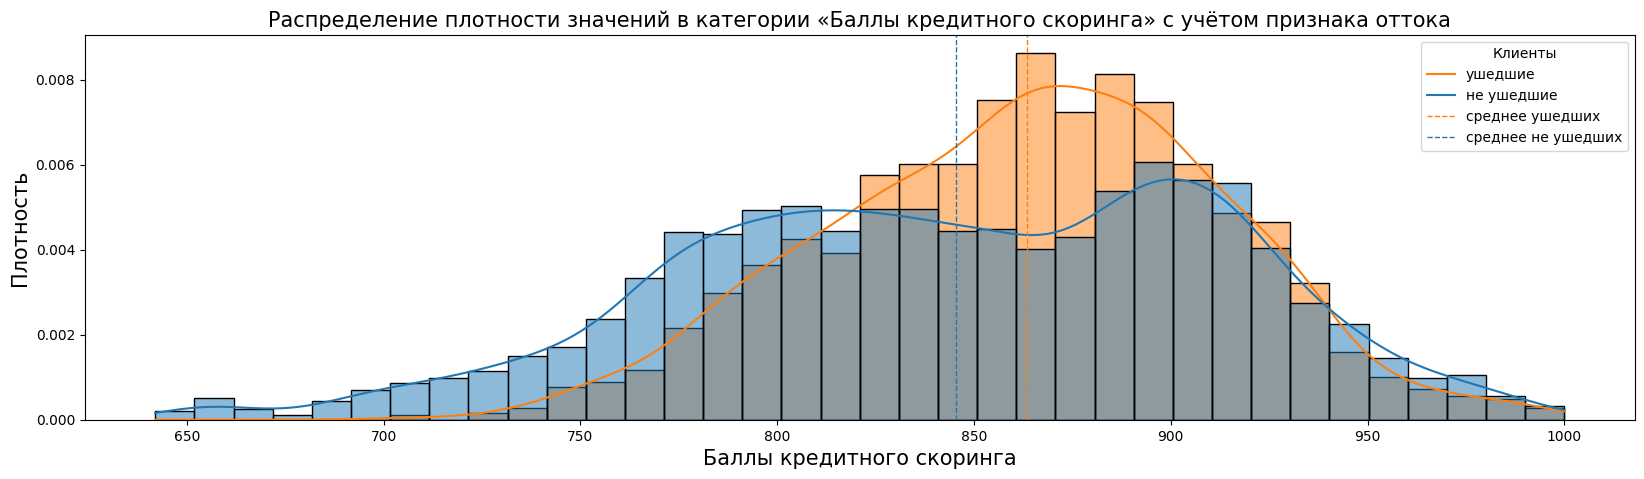

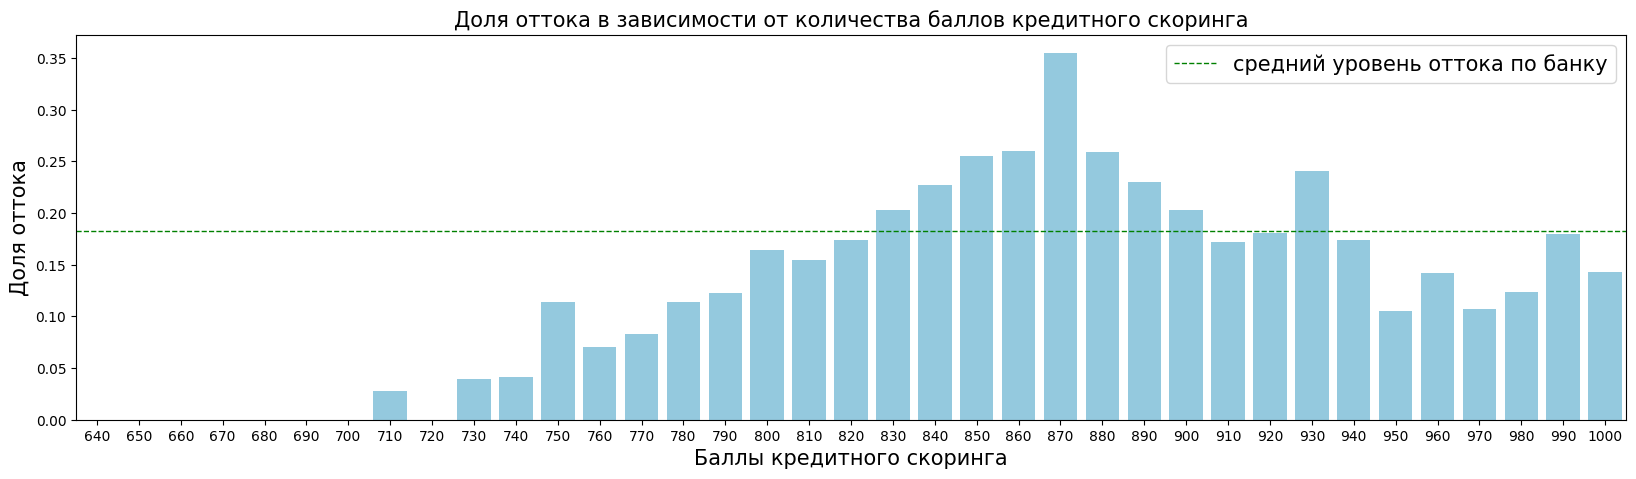

In [24]:
# график №1 - гистограмма плотности признака с делением по оттоку

plt.figure(figsize=(20, 5))

sns.histplot(
    data=data,
    x="score",
    hue="churn",
    stat="density",
    common_norm=False,
    kde=True,
    binwidth=10,
)
plt.title(
    "Распределение плотности значений в категории «Баллы кредитного скоринга» с учётом признака оттока",
    fontsize="15",
)
plt.xlabel("Баллы кредитного скоринга", fontsize="15")
plt.ylabel("Плотность", fontsize="15")


plt.axvline(
    data.query("churn == 1")["score"].mean(),
    color="#ff7f0e",
    linestyle="--",
    linewidth=1,
)

plt.axvline(
    data.query("churn == 0")["score"].mean(),
    color="#1f77b4",
    linestyle="--",
    linewidth=1,
)

plt.legend(
    fontsize=10,
    title="Клиенты",
    loc="upper right",
    labels=["ушедшие",
            "не ушедшие",
            'среднее ушедших',
            'среднее не ушедших']
)

# график №2 - столбчатая диаграмма, отражающая средний уровень оттока для каждого количества баллов,
# округлённого до десятков

# создаем вспомогательный столбец с округленными значениями
data["score_rounded"] = round(data["score"], -1)

# групируем данные по новому столбцу и считаем для каждого значения долю оттока
grouped_data = data.groupby(by="score_rounded")["churn"].mean().to_frame().reset_index()
grouped_data["score_rounded"] = grouped_data["score_rounded"].astype("string")

plt.figure(figsize=(20, 5))
sns.barplot(data=grouped_data, x="score_rounded", y="churn", ci=None, color="skyblue")
plt.axhline(overall_churn, color="g", linestyle="--", linewidth=1, label="horizontal")
plt.legend(loc="upper right", fontsize=15, labels=["средний уровень оттока по банку"])
plt.title(
    "Доля оттока в зависимости от количества баллов кредитного скоринга", fontsize="15"
)
plt.xlabel("Баллы кредитного скоринга", fontsize="15")
plt.ylabel("Доля оттока", fontsize="15");

* **Баллы кредитного скоринга:** 

На основе графиков можно разделить клиентов на следующие сегменты по количеству баллов:
* менее 830 баллов
* от 830 до 930 баллов
* более 930 баллов

Среди клиентов, у которых от 830 до 930 баллов по кредитному скорингу, наблюдается повышенная склонность к оттоку. При этом у тех клиентов, которые ушли, средний кредитный скоринг выше.

#### Баланс на счёте

Построим диаграмму размаха для этого признака, чтобы проверить наличие выбросов.

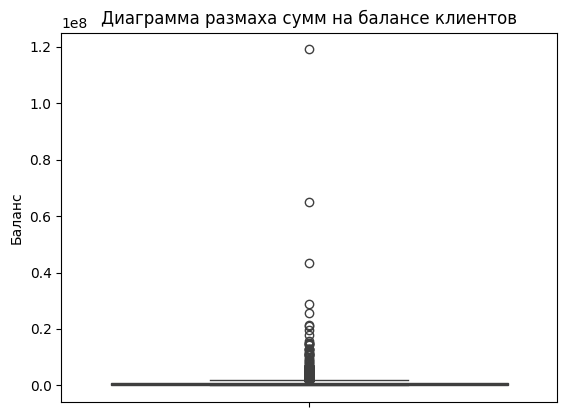

In [25]:
sns.boxplot(data=data, y="balance")

plt.title("Диаграмма размаха сумм на балансе клиентов")
plt.ylabel("Баланс");

Из-за выбросов, саму диаграмму довольно плохо видно, приблизим ее, задав лимит по оси `y`

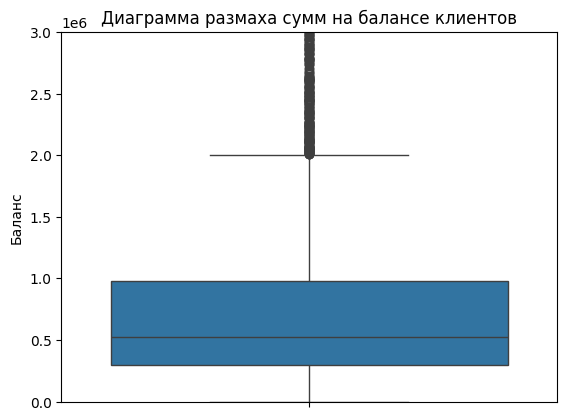

In [26]:
sns.boxplot(data=data, y="balance")
plt.ylim(0, 3000000)

plt.title("Диаграмма размаха сумм на балансе клиентов")
plt.ylabel("Баланс");

Большинство значений находятся в пределах 2000 000.
Дополнительно уточним 99-й и 95-й перцентили и выберем лимит на основе этих значений.

In [27]:
print(
    "95% перцентиль распределения баланса пользователей —",
    np.percentile(data.query("balance >= 0")["balance"], [95])[0],
)
print(
    "99% перцентиль распределения баланса пользователей —",
    np.percentile(data.query("balance >= 0")["balance"], [99])[0],
)

95% перцентиль распределения баланса пользователей — 2114078.393999996
99% перцентиль распределения баланса пользователей — 4827211.159


Определим как верхний лимит — 3 000 000. Затем подсчитаем, сколько строк будет удалено при отсечении аномально высоких значений.

In [28]:
print(
    "Доля пользователей с балансом > 3000000:",
    round(len(data.query("balance > 3000000")) / data.shape[0] * 100, 1),
    "%",
)
print("Количество таких пользоватетей:", len(data.query("balance > 3000000")))

Доля пользователей с балансом > 3000000: 2.0 %
Количество таких пользоватетей: 200


In [29]:
print(
    "Доля пользователей с балансом > 3000000:",
    round(len(data.query("balance > 3000000")) / len(data.query("~balance.isna()")) * 100, 1),
    "%",
)
print("Количество таких пользоватетей:", len(data.query("balance > 3000000")))

Доля пользователей с балансом > 3000000: 2.6 %
Количество таких пользоватетей: 200


Всего 200 строк, 2,6% от общего количества данных. Отсечем эти значения.

In [30]:
data = data.query("balance <= 3000000 or balance.isna()")

Теперь создадим две визуализации:

* гистограмму, которая покажет распределение плотности по признаку оттока;
* столбчатую диаграмму, отражающую средний уровень оттока для каждых 100 000 на балансе

Для этого сначала поделим значения столбца `balance` на 1 тыс., чтобы привести их в более удобный вид.\
Затем создадим дополнительный столбец `balance_rounded_thousands`, в котором округлим значения столбца 'balance' до 100 000.

In [31]:
data["balance"] = data["balance"] / 1000
data["balance_rounded_thousands"] = round(data["balance"], -2)

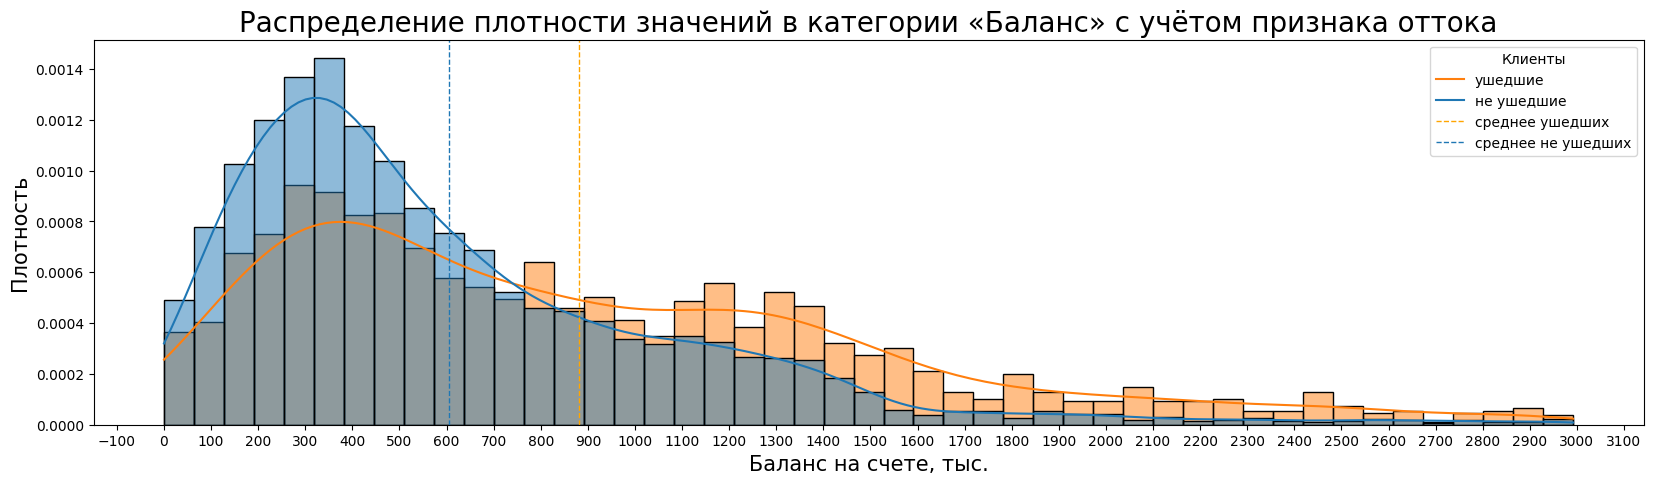

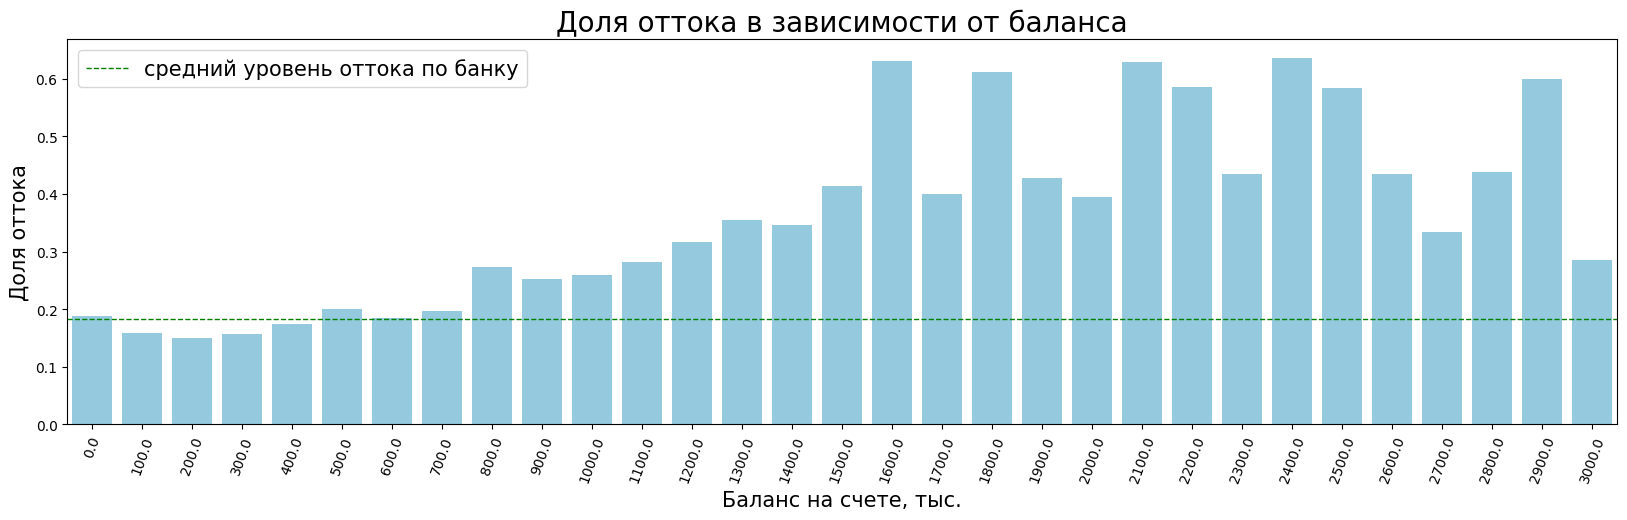

In [32]:
# график №1 - гистограмма плотности признака с делением по оттоку

plt.figure(figsize=(20, 5))
sns.histplot(
    data=data, x="balance", hue="churn", stat="density", common_norm=False, kde=True
)

plt.axvline(
    data.query("churn == 1")["balance"].mean(),
    color="orange",
    linestyle="--",
    linewidth=1,
)

plt.axvline(
    data.query("churn == 0")["balance"].mean(),
    color="#1f77b4",
    linestyle="--",
    linewidth=1,
)

plt.title(
    "Распределение плотности значений в категории «Баланс» с учётом признака оттока",
    fontsize="20",
)
plt.xlabel("Баланс на счете, тыс.", fontsize="15")
plt.ylabel("Плотность", fontsize="15")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

plt.legend(
    fontsize=10,
    title="Клиенты",
    loc="upper right",
    labels=["ушедшие",
            "не ушедшие",
            'среднее ушедших',
            'среднее не ушедших']
)

# график №2 - столбчатая диаграмма, отражающая средний уровень оттока для каждых 100 тыс. на балансе
# групируем данные по новому столбцу и считаем для каждого значения долю оттока
grouped_data = (
    data.groupby(by="balance_rounded_thousands")["churn"]
    .mean()
    .to_frame()
    .reset_index()
)
grouped_data["balance_rounded_thousands"] = grouped_data[
    "balance_rounded_thousands"
].astype("string")

# строим график
plt.figure(figsize=(20, 5))
sns.barplot(
    data=grouped_data,
    x="balance_rounded_thousands",
    y="churn",
    ci=None,
    color="skyblue",
)

plt.axhline(overall_churn, color="g", linestyle="--", linewidth=1, label="horizontal")
plt.legend(loc="upper left", fontsize=15, labels=["средний уровень оттока по банку"])
plt.xticks(rotation=70)

plt.title("Доля оттока в зависимости от баланса", fontsize="20")
plt.xlabel("Баланс на счете, тыс.", fontsize="15")
plt.ylabel("Доля оттока", fontsize="15");

**Наблюдения:**

На основе графиков можно разделить клиентов на следующие сегменты по сумме на балансе:
* меньше 700 тысяч;
* больше 700 тысяч.

Клиенты с суммой на балансе более 700 тысяч наиболее склонны к оттоку.
В среднем у клиентов, которые ушли, сумма на балансе больше.

#### Оценочный доход клиента

Построим диаграмму размаха для этого признака по аналогии с предыдущим столбцом, чтобы определить, есть ли выбросы.

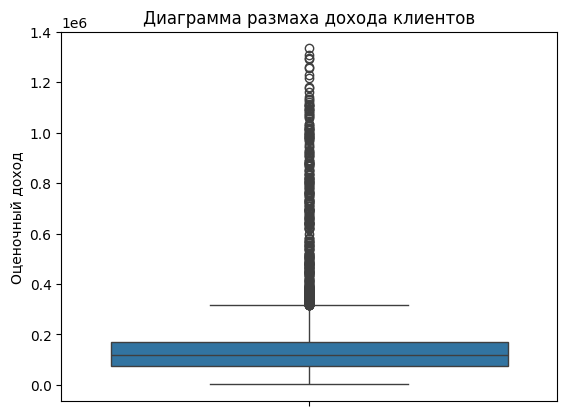

In [33]:
sns.boxplot(data=data, y="est_salary")

plt.title("Диаграмма размаха дохода клиентов")
plt.ylabel("Оценочный доход");

Уточним 99-й и 95-й перцентили, чтобы определить лимит по доходу.

In [34]:
print(
    "95% перцентиль распределения дохода пользователей —",
    np.percentile(data["est_salary"], [95])[0],
)
print(
    "99% перцентиль распределения дохода пользователей —",
    np.percentile(data["est_salary"], [99])[0],
)

95% перцентиль распределения дохода пользователей — 291002.2359999999
99% перцентиль распределения дохода пользователей — 805587.5796000003


Выберем за верхний лимит значение — 500 000.\
Проверим, сколько строк мы удалим, если отсечем аномально высокие значения.

In [35]:
print(
    "Доля пользователей с балансом > 3000000:",
    round(len(data.query("est_salary > 500000")) / data.shape[0] * 100, 1),
    "%",
)
print("Количество таких пользоватетей:", len(data.query("est_salary > 500000")))

Доля пользователей с балансом > 3000000: 2.1 %
Количество таких пользоватетей: 206


Всего 206 строк, ~2% от общего количества данных. Отсечем эти значения.

In [36]:
data = data.query("est_salary <= 500000")

Теперь создадим две визуализации:

* гистограмму, которая покажет распределение плотности по признаку оттока;
* столбчатую диаграмму, отражающую средний уровень оттока для каждых 100 000 на балансе

Для этого сначала поделим значения столбца `est_salary` на 1 тыс., чтобы привести их в более удобный вид.\
Затем создадим дополнительный столбец `est_salary_rounded_thousands`, в котором округлим значения столбца 'est_salary' до 10 000.

In [37]:
data["est_salary"] = data["est_salary"] / 1000
data["est_salary_rounded_thousands"] = round(data["est_salary"], -1)

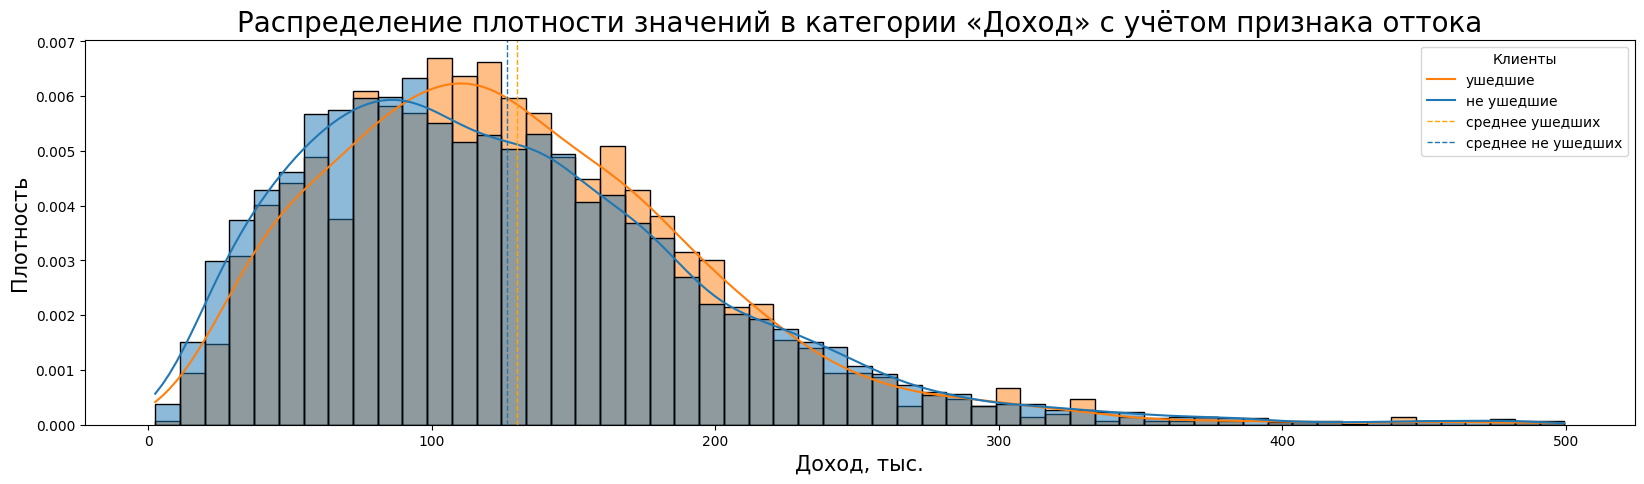

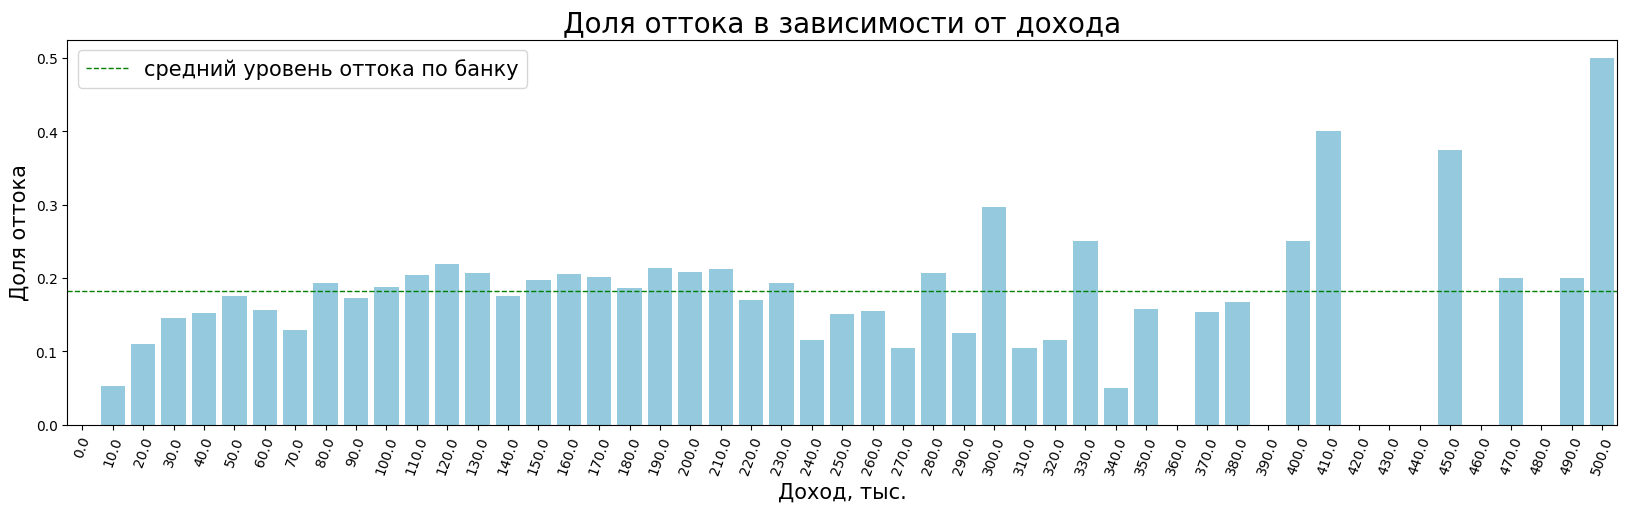

In [38]:
# график №1 - гистограмма плотности признака с делением по оттоку

plt.figure(figsize=(20, 5))
sns.histplot(
    data=data, x="est_salary", hue="churn", stat="density", common_norm=False, kde=True
)

plt.axvline(
    data.query("churn == 1")["est_salary"].mean(),
    color="orange",
    linestyle="--",
    linewidth=1,
)

plt.axvline(
    data.query("churn == 0")["est_salary"].mean(),
    color="#1f77b4",
    linestyle="--",
    linewidth=1,
)

plt.title(
    "Распределение плотности значений в категории «Доход» с учётом признака оттока",
    fontsize="20",
)
plt.xlabel("Доход, тыс.", fontsize="15")
plt.ylabel("Плотность", fontsize="15")


plt.legend(
    fontsize=10,
    title="Клиенты",
    loc="upper right",
    labels=["ушедшие",
            "не ушедшие",
            'среднее ушедших',
            'среднее не ушедших']
)

# график №2 - столбчатая диаграмма, отражающая средний уровень оттока для каждых 100 тыс. на балансе
# групируем данные по новому столбцу и считаем для каждого значения долю оттока
grouped_data = (
    data.groupby(by="est_salary_rounded_thousands")["churn"]
    .mean()
    .to_frame()
    .reset_index()
)
grouped_data["est_salary_rounded_thousands"] = grouped_data[
    "est_salary_rounded_thousands"
].astype("string")

# строим график
plt.figure(figsize=(20, 5))
sns.barplot(
    data=grouped_data,
    x="est_salary_rounded_thousands",
    y="churn",
    ci=None,
    color="skyblue",
)

plt.axhline(overall_churn, color="g", linestyle="--", linewidth=1, label="horizontal")
plt.legend(loc="upper left", fontsize=15, labels=["средний уровень оттока по банку"])
plt.xticks(rotation=70)

plt.title("Доля оттока в зависимости от дохода", fontsize="20")
plt.xlabel("Доход, тыс.", fontsize="15")
plt.ylabel("Доля оттока", fontsize="15");

**Наблюдения:**

На основе графиков можно разделить клиентов на следующие сегменты по оценочной зарплате:
* меньше 80 тысяч;
* от 80 до 230 тысяч
* больше 230.

Среди клиентов чуть больше склонны к оттоку те, чей доход составляет от 80 до 230 тысяч. Для клиентов с доходом выше 280 тысяч также характерен высокий средний отток, но таких клиентов всего несколько десятков, поэтому эта информация не может быть надёжной основой для выводов.
В среднем ушедшие клиенты имеют более высокий уровень дохода по сравнению с оставшимися клиентами. Однако разница несущественна, далее мы проверим гипотезу о различии в доходах между ушедшими и оставшимися клиентами.

###  Корреляционный анализ

Для определения силы связи между признаками применим метод `phik_matrix` библиотеки `phik`. И на основе результатов подсчета построим тепловую карту.

Перед этим удалим лишние вспомогательные столбцы, созданные ранее.

In [39]:
# удаление столбцов
data = data.drop(
    columns=[
        "score_rounded",
        "balance_rounded_thousands",
        "est_salary_rounded_thousands",
    ]
)

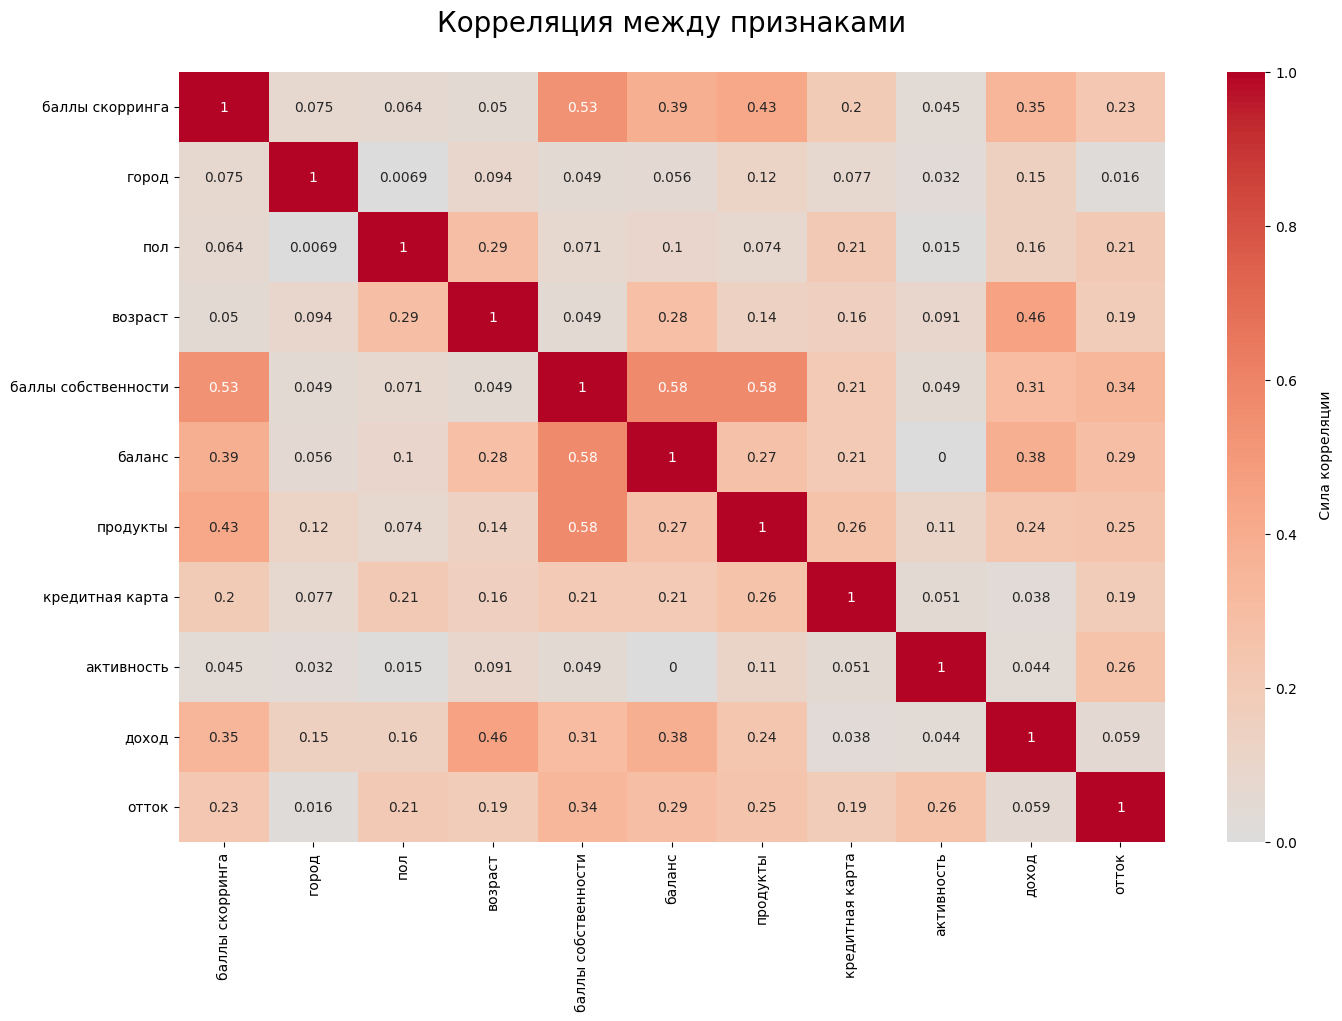

In [40]:
# создаем матрицу корреляции 
correlation = data.phik_matrix(interval_cols=["age", "est_salary", "balance", "score"])


correlation.columns = ['баллы скорринга',
                        'город',
                        'пол',
                        'возраст',
                        'баллы собственности',
                        'баланс',
                        'продукты',
                        'кредитная карта',
                        'активность',
                        'доход',
                        'отток'
                       ]
correlation.index = correlation.columns

# создаем тепловую карту на основе этой матрицы
plt.figure(figsize=(35, 10))

sns.heatmap(
    correlation,
    ax=plt.subplot(1, 2, 1),
    cmap="coolwarm",
    center=0,
    annot=True,
    cbar_kws={"label": "\n Сила корреляции"},
)


plt.title("Корреляция между признаками\n", fontsize="20");

Отдельно посмотрим на взаимосвязь между признаком оттока и всеми остальными признаками. Отсортируем по мере убывания силы связи.

In [41]:
round(correlation["отток"].sort_values(ascending=False), 3)

отток                  1.000
баллы собственности    0.338
баланс                 0.294
активность             0.260
продукты               0.252
баллы скорринга        0.232
пол                    0.212
возраст                0.191
кредитная карта        0.191
доход                  0.059
город                  0.016
Name: отток, dtype: float64

Для оценки силы связи в теории корреляции применим шкалу английского статистика Чеддока:
* oчень слабая — от 0,1 до 0,3
* слабая — от 0,3 до 0,5
* средняя — от 0,5 до 0,7
* высокая — от 0,7 до 0,9
* очень высокая — от 0,9 до 1,0

**Наблюдения:**
    
**Наблюдается слабая или очень слабая корреляция между оттоком и другими признаками.** Выделим четыре признака, сильнее всего коррелирующие с оттоком:
* `equity` — количеством баллов собственности
* `balance` — баланс на счёте,
* `last_activity` — активный клиент,
* `products` — количество продуктов, которыми пользуется клиент.

В целом по данным можно также отметить следующие взаимосвязи:
* средняя связь между баллами собственности и балансом;
* средняя связь между баллами собственности и количеством продуктов банка;
* средняя связь между баллами собственности и баллами скоринга.

### Промежуточный вывод

Мы провели исследовательский и корреляционный анализы и выявили следующее закономерности:

* **Город:** клиенты из Ярославля и Ростова имеют уровень оттока выше среднего. Больше всего клиентов из Ярославля.
* **Пол:** мужчины демонстрируют значительно более высокий уровень оттока, чем женщины. В датафрейме примерно равное количество мужчин и женщин.
* **Количество баллов собственности:** у клиентов с тремя и более баллами собственности уровень оттока выше среднего по банку. При этом большинство клиентов имеют нулевой балл собственности.
* **Количество продуктов банка:** клиенты, пользующиеся двумя и более продуктами банка, имеют уровень оттока выше среднего по банку. У большинства клиентов два или один продукт.
* **Наличие кредитной карты:** клиенты без кредитной карты банка более склонны к оттоку, хотя таких клиентов меньше.
* **Активность за последний месяц:** клиенты, активные в последний месяц, более склонны к оттоку. Их немного больше в датасете.
* **Возраст:** В среднем клиентам банка 40 лет. Наибольшую склонность к оттоку демонстрируют клиенты в возрасте 25-35 и 50-60 лет. В среднем ушедшие клиенты немного моложе оставшихся.
* **Баллы кредитного скоринга:** Среди клиентов, у которых от 830 до 930 баллов по кредитному скорингу, наблюдается повышенная склонность к оттоку. При этом у тех клиентов, которые ушли, средний кредитный скоринг выше.
* **Сумма на балансе:** Клиенты с суммой на балансе более 700 тысяч наиболее склонны к оттоку.
В среднем у клиентов, которые ушли, сумма на балансе больше.
* **Доход клиента:** Среди клиентов чуть больше склонны к оттоку те, чей доход составляет от 80 до 230 тысяч. Ушедшие клиенты в среднем имеют более высокий уровень дохода, чем оставшиеся.


* **Корреляционный анализ:** Наблюдается **слабая или очень слабая** корреляция между оттоком и другими признаками. Четыре признака, сильнее всего коррелирующие с оттоком:
    * количеством баллов собственности
    * баланс на счёте,
    * активность клиента,
    * количество продуктов, которыми пользуется клиент.

## Формулировка и проверка гипотез


### Гипотеза №1

*Между доходами клиентов, которые ушли, и доходами тех, кто остался, есть статистически значимое различие.*

**Формулируем гипотезу:**

Будем сравнивать две выборки:

Первая выборка — доходы ушедших клиентов\
Вторая выборка — доходы оставшихся клиентов

**Нулевая гипотеза** — среднее значение доходов ушедших из банка клиентов `=` среднему значению доходов оставшихся в банке клиентов 
**Альтернативная гипотеза** — среднее значение доходов ушедших из банка клиентов `!=` среднему значению доходов оставшихся в банке клиентов 

Таким образом альтернативная гипотеза — двусторонняя.

---

Чтобы понять, можем ли мы применить в данном случае t-тест Стьюдента проверим выборки на нормальность распределения.

In [42]:
# формируем выборки
sample_1 = data.query("churn == 0")["est_salary"]
sample_2 = data.query("churn == 1")["est_salary"]

In [43]:
alpha = .05 # критический уровень статистической значимости

#тестируем первую выборку на нормальность
results = st.shapiro(sample_1)
p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

#тестируем вторую выборку на нормальность
results = st.shapiro(sample_2)
p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

p-значение:  1.642406281162377e-50
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  3.995839320876573e-25
Отвергаем нулевую гипотезу: распределение не нормально


**Распределения не являются нормальным, поэтому будем проводить непараметрический тест Уилкоксона-Манна-Уитни.**

In [44]:
results = st.mannwhitneyu(sample_1, sample_2)

print("p-значение: ", results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.0013218736518646594
Отвергаем нулевую гипотезу: разница статистически значима


**Вывод** 

Полученное значение p-value значительно меньше заданного уровня значимости, есть основания предположить, **среднее значение доходов ушедших из банка клиентов не равна среднему значению доходов оставшихся в банке клиентов.**

Интересный результат, так как и корреляционный анализ и графики показали достаточно низкое влияние дохода на отточность.

### Гипотеза №2

*Между балансом клиентов, которые ушли, и балансом тех, кто остался, есть статистически значимое различие.*

**Формулируем гипотезу:**

Будем сравнивать две выборки:

Первая выборка - баланс ушедших клиентов\
Вторая выборка - баланс оставшихся клиентов

**Нулевая гипотеза** — среднее значение баланса ушедших из банка клиентов `=` среднему значению баланса оставшихся в банке клиентов 
**Альтернативная гипотеза** — среднее значение баланса ушедших из банка клиентов `!=` среднему значению баланса оставшихся в банке клиентов 

Таким образом альтернативная гипотеза — двусторонняя.

---

Чтобы понять, можем ли мы применить в данном случае t-тест Стьюдента проверим выборки на нормальность распределения.

In [45]:
# формируем выборки
sample_1 = data.query("churn == 0 and balance>=0")["balance"]
sample_2 = data.query("churn == 1 and balance>=0")["balance"]

In [46]:
#тестируем первую выборку на нормальность
results = st.shapiro(sample_1)
p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

#тестируем вторую выборку на нормальность
results = st.shapiro(sample_2)
p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

p-значение:  6.473909115750005e-57
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  5.008916135724261e-29
Отвергаем нулевую гипотезу: распределение не нормально


**Распределения не являются нормальным, поэтому будем проводить непараметрический тест Уилкоксона-Манна-Уитни.**

In [47]:
results = st.mannwhitneyu(sample_1, sample_2)

print("p-значение: ", results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  5.16965081309199e-60
Отвергаем нулевую гипотезу: разница статистически значима


**Вывод** 

Полученное значение p-value значительно меньше заданного уровня значимости, есть основания предположить, что **средняя сумма на балансе ушедших из банка клиентов не равна средней сумме на балансе оставшихся в банке клиентов.**

Этот вывод согласуется с корреляционным анализом и построенными графиками.

### Гипотеза №3

*Доля ушедших между клиентами мужчинами и женщинами различна.*

**Формулируем гипотезу:**

Для этого сравнения мы будем использовать следующую формулировку гипотезы о равенстве долей:

**Нулевая гипотеза** — доли ушедших клиентов различаются для мужчин и женщин.\
**Альтернативная гипотеза** — доли ушедших клиентов среди мужчин и женщин не различаются.

Таким образом альтернативная гипотеза — двусторонняя.

---

Сформируем выборки и проверим их размер.

In [48]:
# формируем выборки
sample_1 = data.query('gender == "Ж"')["churn"]
sample_2 = data.query('gender == "М"')["churn"]

print(len(sample_2)/len(sample_1))

0.9840315221899627


Размер выборок достаточно близкий.

Проведем проверку гипотезу о равенстве долей:

In [49]:
# доля оттока в первой группе:
p1 = sample_1.mean()

# доля оттока во второй группе:
p2 = sample_2.mean()

# доля оттока в комбинированном датасете:
p_combined = data['churn'].mean()
difference = p1 - p2 # разница пропорций в датасетах

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/len(sample_1) + 1/len(sample_2)))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

#вычисляем p-value
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-value: ', p_value)

#сравниваем p-value с задананным значением alpha
if p_value < alpha:# ваш код
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-value:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод** 

**Есть статистически значимая разница между долями ушедших клиентов среди мужчин и женщин.**
Этот вывод согласуется с корреляционным анализом и построенными графиками.

### Промежуточный вывод

Мы сформулировали и проверили ряд гипотез:

**Гипотеза №1** — Между доходами клиентов, которые ушли, и доходами тех, кто остался, есть статистически значимое различие.\
**Результат проверки гипотезы:** есть основания полагать, что среднее значение доходов ушедших клиентов не равно среднему значению доходов оставшихся клиентов.

**Гипотеза №2** — Между балансом клиентов, которые ушли, и балансом тех, кто остался, есть статистически значимое различие.\
**Результат проверки гипотезы**: есть основания предполагать, что средняя сумма на балансе ушедших из банка клиентов неравна средней сумме на балансе оставшихся в банке клиентов.


**Гипотеза №3** — Доля ушедших между клиентами мужчинами и женщинами различна.\
**Результат проверки гипотезы**: есть основания считать, что существует статистически значимая разница между долями ушедших клиентов среди мужчин и женщин.

## Значимые признаки отточности

Напомним, что **средний уровень оттока по банку равен 18.23%**

На основании проведенного исследовательского анализа мы выделили сегменты и категории склонные к оттоку выше среднего по банку. Уточним доли оттока в каждой категории.

### Баланс на счете

Мы выяснили, что клиенты с суммой на балансе более 700 тысяч наиболее склонны к оттоку.
Посчитаем уровень оттока для клиентов в этом промежутке и количество клиентов с таким признаком.

In [50]:
print('Доля оттока в сегменте "более 700 тыс. на балансе" равна', round(data.query('balance >= 700')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('balance >= 700')),'человек')

Доля оттока в сегменте "более 700 тыс. на балансе" равна 0.33
Количество клиентов в сегменте равно 2678 человек


### Возраст

Наибольшую склонность к оттоку демонстрируют клиенты в возрасте 25-35 и 50-60 лет.
Посчитаем уровень оттока для клиентов в этих возрастных промежутках и количество клиентов с таким признаком.

In [51]:
print('Доля оттока в сегменте "25-35 лет" равна', round(data.query('age >= 25 and age <= 35')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('age >= 25 and age <= 35')),'человек')

Доля оттока в сегменте "25-35 лет" равна 0.215
Количество клиентов в сегменте равно 2945 человек


In [52]:
print('Доля оттока в сегменте "50-60 лет" равна', round(data.query('age >= 50 and age <= 60')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('age >= 50 and age <= 60')),'человек')

Доля оттока в сегменте "50-60 лет" равна 0.261
Количество клиентов в сегменте равно 1674 человек


### Количество баллов собственности

Мы выяснили, что у клиентов с тремя и более баллами собственности уровень оттока выше среднего по банку.
Посчитаем уровень оттока для клиентов в этом промежутке и количество клиентов с таким признаком.

In [53]:
print('Доля оттока в сегменте "3 и более баллов собственности" равна', round(data.query('equity >= 3')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('equity >= 3')),'человек')

Доля оттока в сегменте "3 и более баллов собственности" равна 0.256
Количество клиентов в сегменте равно 5359 человек


### Кредитная карта

Среди клиентов, у которых отсутствует кредитная карта, наблюдается повышенная склонность к оттоку.
Посчитаем уровень оттока для клиентов в этом промежутке и количество клиентов с таким признаком.

In [54]:
print('Доля оттока в сегменте "отсутствие кредитной карты" равна', round(data.query('credit_card == 0')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('credit_card == 0')),'человек')

Доля оттока в сегменте "отсутствие кредитной карты" равна 0.248
Количество клиентов в сегменте равно 3045 человек


### Активность

Клиенты, активные в последний месяц, более склонны к оттоку.
Посчитаем уровень оттока для активных клиентов и количество клиентов с таким признаком.

In [55]:
print('Доля оттока в сегменте "активные клиенты" равна', round(data.query('last_activity == 1')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('last_activity == 1')),'человек')

Доля оттока в сегменте "активные клиенты" равна 0.241
Количество клиентов в сегменте равно 4984 человек


### Пол

Мы установили, что мужчины чаще уходят из банка.
Давайте рассчитаем уровень оттока среди мужчин и определим количество таких клиентов.

In [56]:
print('Доля оттока в сегменте "мужчины" равна', round(data.query('gender == "М"')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('gender == "М"')),'человек')

Доля оттока в сегменте "мужчины" равна 0.232
Количество клиентов в сегменте равно 4745 человек


### Продукты банка

Мы выяснили, что клиенты, пользующиеся двумя и более продуктами банка, имеют уровень оттока выше среднего по банку.
Посчитаем уровень оттока для клиентов в этом промежутке и количество клиентов с таким признаком.

In [57]:
print('Доля оттока в сегменте "более одного продукта банка" равна', round(data.query('products > 1')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('products > 1')),'человек')

Доля оттока в сегменте "более одного продукта банка" равна 0.232
Количество клиентов в сегменте равно 6411 человек


### Баллы кредитного скоринга

Среди клиентов, у которых от 830 до 930 баллов по кредитному скорингу, наблюдается повышенная склонность к оттоку.
Посчитаем уровень оттока для клиентов в этом промежутке и количество клиентов с таким признаком.

In [58]:
print('Доля оттока в сегменте "830-930 баллов кредитного скоринга" равна',
      round(data.query('score >= 830 and score <= 930')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('score >= 830 and score <= 930')),'человек')

Доля оттока в сегменте "830-930 баллов кредитного скоринга" равна 0.227
Количество клиентов в сегменте равно 5086 человек


### Доход

Среди клиентов чуть больше склонны к оттоку те, чей доход составляет от 80 до 230 тысяч. 
Посчитаем уровень оттока для активных клиентов и количество клиентов с таким доходом.

In [59]:
print('Доля оттока в сегменте "предполагаемый доход — 80-230 тыс." равна',
      round(data.query('est_salary >= 80 and est_salary <= 230')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('est_salary >= 80 and est_salary <= 230')),'человек')

Доля оттока в сегменте "предполагаемый доход — 80-230 тыс." равна 0.196
Количество клиентов в сегменте равно 5994 человек


### Город

Клиенты из Ярославля и Ростова имеют уровень оттока выше среднего. При этом уровень оттока жителей этих городов не сильно выше среднего по банку.

Посчитаем уровень оттока для клиентов в этих городах и количество клиентов.

In [60]:
print('Доля оттока в сегменте "Ярославль" равна', round(data.query('city == "Ярославль"')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('city == "Ярославль"')),'человек')

Доля оттока в сегменте "Ярославль" равна 0.186
Количество клиентов в сегменте равно 5566 человек


In [61]:
print('Доля оттока в сегменте "Ростов" равна', round(data.query('city == "Ростов"')['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(data.query('city == "Ростов"')),'человек')

Доля оттока в сегменте "Ростов" равна 0.185
Количество клиентов в сегменте равно 1404 человек


### Промежуточный вывод

На основании созданных выше сегментов сформулируем **портрет клиента, склонного к уходу**:

Это мужчина, проживающий в Ярославле или Ростове, в возрасте от 25 до 35 лет или от 50 до 60 лет.
Он не пользуется кредитной картой, но применяет более одного продукта банка. Активный за последний месяц. 
Его доход составляет от 80 до 230 тысяч, у него есть собственность, оцениваемая более чем в два балла, а на его балансе находится свыше 700 тысяч. Баллы скоринга находятся в диапазоне от 830 до 930.


Также можно определить **портрет клиента, не склонного к уходу**:

Это женщина из Рыбинска в возрасте до 24 лет или от 36 до 49 лет.
Она пользуется кредитной картой, но другими продуктами банка не пользуется. В течение последнего месяца она не проявляла активности. На её балансе находится менее 700 тысяч, а доход составляет менее 80 тысяч.У неё есть собственность, оцениваемая до трёх баллов. Баллы скоринга находятся в диапазоне ниже 830 либо выше 930.

Определим шесть признаков и их интервалы, которые сильнее всего влияют на вероятность оттока клиентов:
* баланс на счёте более 700 тысяч;
* возраст от 25 до 35 лет или от 50 до 60 лет;
* наличие собственности, оцениваемой более чем в два балла;
* отсутствие кредитной карты;
* активность за последний месяц;
* мужской пол.

## Сегментация

На основе выявленных выше признаков отточности, выделим несколько групп клиентов, склонных уходить из банка.

### Сегмент №1

* Мужчина
* C тремя и более баллами собственности
* Без кредитной карты

In [62]:
# сохраняем срез данных в отдельную переменную
segment_1 = data.query('gender == "М" and credit_card == 0 and equity >= 3')

# добавляем данные по сегменту в словарь
segment_dict = {'Сегмент': ['Сегмент №1'],
        'Общее количество клиентов': [len(segment_1)],
        'Количество ушедших': [len(segment_1.query('churn == 1'))],
        'Доля оттока': [round(segment_1['churn'].mean(),3)]
       }

# Выводим на экран данные по сегменту
print('Доля оттока в первом сегменте равна',
      round(segment_1['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(segment_1),'человек')
print('Количество ушедших клиентов в сегменте равно', len(segment_1.query('churn == 1')),'человек')

Доля оттока в первом сегменте равна 0.464
Количество клиентов в сегменте равно 810 человек
Количество ушедших клиентов в сегменте равно 376 человек


### Сегмент №2

* Без кредитной карты
* Возраст от 50 до 60 лет

In [63]:
# сохраняем срез данных в отдельную переменную
segment_2 = data.query('age >= 50 and age <= 60 and credit_card == 0')

# добавляем данные по сегменту в словарь
segment_dict['Сегмент'].append('Сегмент №2')
segment_dict['Общее количество клиентов'].append(len(segment_2))
segment_dict['Количество ушедших'].append(len(segment_2.query('churn == 1')))
segment_dict['Доля оттока'].append(round(segment_2['churn'].mean(),3))

# выводим на экран данные по сегменту
print('Доля оттока во втором сегменте равна',
      round(segment_2['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(segment_2),'человек')
print('Количество ушедших клиентов в сегменте равно', len(segment_2.query('churn == 1')),'человек')

Доля оттока во втором сегменте равна 0.346
Количество клиентов в сегменте равно 659 человек
Количество ушедших клиентов в сегменте равно 228 человек


### Сегмент №3

* Возраст 25-35 лет
* пользующиеся более чем одним продуктом банка
* более 700 тыс. на балансе

In [64]:
# сохраняем срез данных в отдельную переменную
segment_3 = data.query('balance >= 700 and age >= 25 and age <= 35 and products > 1')

# добавляем данные по сегменту в словарь
segment_dict['Сегмент'].append('Сегмент №3')
segment_dict['Общее количество клиентов'].append(len(segment_3))
segment_dict['Количество ушедших'].append(len(segment_3.query('churn == 1')))
segment_dict['Доля оттока'].append(round(segment_3['churn'].mean(),3))

# выводим на экран данные по сегменту
print('Доля оттока в третьем сегменте равна',
      round(segment_3['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(segment_3),'человек')
print('Количество ушедших клиентов в сегменте равно', len(segment_3.query('churn == 1')),'человек')

Доля оттока в третьем сегменте равна 0.5
Количество клиентов в сегменте равно 546 человек
Количество ушедших клиентов в сегменте равно 273 человек


### Сегмент №4

* Активные за последний месяц
* более 700 тыс. на балансе
* C тремя и более баллами собственности

In [65]:
# сохраняем срез данных в отдельную переменную
segment_4 = data.query('balance >= 700 and equity >= 3 and last_activity == 1')

# добавляем данные по сегменту в словарь
segment_dict['Сегмент'].append('Сегмент №4')
segment_dict['Общее количество клиентов'].append(len(segment_4))
segment_dict['Количество ушедших'].append(len(segment_4.query('churn == 1')))
segment_dict['Доля оттока'].append(round(segment_4['churn'].mean(),3))

# выводим на экран данные по сегменту
print('Доля оттока в четвертом сегменте равна',round(segment_4['churn'].mean(),3))
print('Количество клиентов в сегменте равно', len(segment_4),'человек')
print('Количество ушедших клиентов в сегменте равно', len(segment_4.query('churn == 1')),'человек')

Доля оттока в четвертом сегменте равна 0.477
Количество клиентов в сегменте равно 1264 человек
Количество ушедших клиентов в сегменте равно 603 человек


### Приоритизация сегментов

Выведем на экран словарь с данными по сегментам. Отсортируем сегменты по мере убывания ушедших клиентов.

In [66]:
pd.DataFrame.from_dict(segment_dict, orient='columns').sort_values(by='Количество ушедших', ascending=False)

,Сегмент,Общее количество клиентов,Количество ушедших,Доля оттока
3,Сегмент №4,1264,603,0.477
0,Сегмент №1,810,376,0.464
2,Сегмент №3,546,273,0.500
1,Сегмент №2,659,228,0.346


* На основе данных из таблицы можно выделить **сегмент №4** как самый многочисленный по количеству ушедших клиентов и занимающий второе место по доле оттока.
* Далее следует **сегмент №1** с уровнем оттока 46% и 376 ушедшими клиентами.
* На третьем месте **сегмент №3**, в котором самая высокая доля оттока - 50%
* **Сегмент №2** наименее приоритетный как по уровню оттока так и по количеству ушедших клиентов

##  Итоги исследования и рекомендации

**Кратко перескажем ход исследования:**

**`Подготовили данные:`** Привели столбцы к единому регистру, обработали дубликаты и пропуски в данных, поменяли типы данных, где это уместно.

**`Выявили несколько признаков и их интервалов, более всего влияющих на отток:`**

* баланс на счёте более 700 тысяч;
* возраст от 25 до 35 лет или от 50 до 60 лет;
* наличие собственности, оцениваемой более чем в два балла;
* отсутствие кредитной карты;
* активность за последний месяц;
* мужской пол.

**`Сформулировали и проверили ряд гипотез:`**

Гипотеза №1 — Между доходами клиентов, которые ушли, и доходами тех, кто остался, есть статистически значимое различие.\
Результат проверки гипотезы: есть основания полагать, что среднее значение доходов ушедших клиентов не равно среднему значению доходов оставшихся клиентов.

Гипотеза №2 — Между балансом клиентов, которые ушли, и балансом тех, кто остался, есть статистически значимое различие.\
Результат проверки гипотезы: есть основания предполагать, что средняя сумма на балансе ушедших из банка клиентов не равна средней сумме на балансе оставшихся в банке клиентов.

Гипотеза №3 — Доля ушедших между клиентами мужчинами и женщинами различна.\
Результат проверки гипотезы: есть основания считать, что существует статистически значимая разница между долями ушедших клиентов среди мужчин и женщин.

**`Выделили четыре сегмента клиентов с долей оттока выше средней по банку:`**

Проведена классификация клиентских сегментов в порядке уменьшения количества ушедших клиентов. Для каждого сегмента разработаны персонализированные рекомендации.

---

### Рекомендации для отдела маркетинга


Сегменты указаны в порядке убывания приоритетности.


**Сегмент №4**

* Активные за последний месяц
* более 700 тыс. на балансе
* C тремя и более баллами собственности

Программы лояльности:

1 — Специальные условия или дополнительные бонусы при оформлении полиса на автомобиль или квартиру, а также страховые пакеты, включающие защиту имущества.\
2 — Повышенный кешбэк на путешествия, покупку электроники и услуги кафе и ресторанов.\
3 — Возможность перевода кэшбэка в мили популярных авиакомпаний.

**Сегмент №1**

* Мужчина
* C тремя и более баллами собственности
* Без кредитной карты

Программы лояльности:

1 — Специальные условия оформления кредитной карты.\
2 — Специальные условия или дополнительные бонусы при оформлении полиса на автомобиль или квартиру, а также страховые пакеты, включающие защиту имущества.\
3 — Бонусы за регулярное пополнение депозита или использование инвестиционных инструментов.

**Сегмент №3**

* Возраст 25-35 лет
* пользующиеся более чем одним продуктом банка
* более 700 тыс. на балансе

Программы лояльности:


1 — Специальные условия или дополнительные бонусы при оформлении.\
2 — Льготное оформление ипотеки\
3 — Повышенный кэшбэк на путешествия, покупку электроники и услуги кафе и ресторанов.\
4 — Возможность перевода кэшбэка в мили популярных авиакомпаний.

**Сегмент №2**

* Возраст от 50 до 60 лет
* Без кредитной карты

Программы лояльности:

1 — Приветственные бонусы за оформление кредитной карты.\
2 — Накопительные бонусы и подарки для лояльных клиентов при будущем оформлении или пенсионных карт в банке.\
3 — Повышенный кэшбэк на платные медицинские услуги, покупку электроники и товары для дачи (данные категории выделены ВЦИОМ в топ-3 потребляемых товаров и услуг в возрастной категории 50-65 лет).